In [2]:
import sys
import os

#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

california_housing = fetch_california_housing()
X, y = california_housing.data, california_housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Now you can import the LinearRegression class
from modules.LinearRegression import LinearRegression 
lr_mse = LinearRegression(learning_rate = 0.001, n_iters=1000, batch_size = 32, init_method = 'random', loss_function='mse')
lr_mse.load_dataset(X_train_scaled, y_train.reshape(-1, 1))
_, _, loss = lr_mse.fit()

Epoch 1/1000, Loss: 2.71107784307772
Epoch 101/1000, Loss: 0.5571146558909932
Epoch 201/1000, Loss: 0.5379524019867733
Epoch 301/1000, Loss: 0.5315124889220688
Epoch 401/1000, Loss: 0.5282865206191288
Epoch 501/1000, Loss: 0.5263476683450482
Epoch 601/1000, Loss: 0.5250544786880499
Epoch 701/1000, Loss: 0.5241275203665843
Epoch 801/1000, Loss: 0.5234345338231791
Epoch 901/1000, Loss: 0.5228950936992534


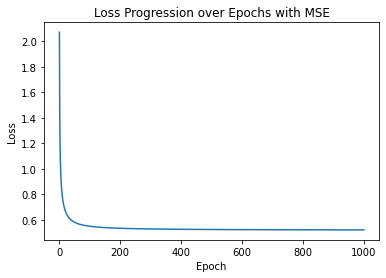

In [8]:
# prompt: Take the loss array and create a line plot showing the loss progression with epochs please

import matplotlib.pyplot as plt

# Assuming 'loss' is the array containing the loss values for each epoch
plt.plot(range(1, lr.n_iters + 1), loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression over Epochs with MSE')
plt.show()


In [3]:
# LinearRegression class with MAE as the error function
from modules.LinearRegression import LinearRegression 
lr = LinearRegression(learning_rate = 0.001, n_iters=1000, batch_size = 32, init_method = 'random', loss_function='mae')
lr.load_dataset(X_train_scaled, y_train.reshape(-1, 1))
_, _, loss = lr.fit()

Epoch 1/1000, Loss: 1.461622876566268
Epoch 101/1000, Loss: 0.552804475523086
Epoch 201/1000, Loss: 0.5323487984359416
Epoch 301/1000, Loss: 0.5253970116345537
Epoch 401/1000, Loss: 0.521885456265727
Epoch 501/1000, Loss: 0.5197658233141085
Epoch 601/1000, Loss: 0.5183477154867181
Epoch 701/1000, Loss: 0.5173327131228008
Epoch 801/1000, Loss: 0.5165706092629879
Epoch 901/1000, Loss: 0.5159773693870401


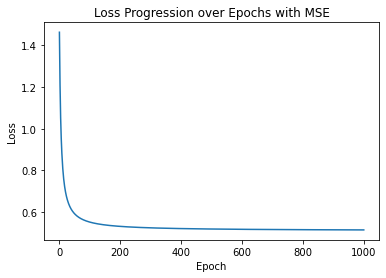

In [4]:
import matplotlib.pyplot as plt

# Assuming 'loss' is the array containing the loss values for each epoch
plt.plot(range(1, lr.n_iters + 1), loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression over Epochs with MSE')
plt.show()


In [6]:
lr.evaluate(X_test_scaled, y_test.reshape(-1, 1)) 

0.5119300539921869